## hard voting: average of classifiers output
Set the parameter `voting='hard'`

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [3]:
X,y = make_moons(n_samples=500, noise=0.3, random_state=42);   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_clf = LogisticRegression(solver='lbfgs')
rnd_clf = RandomForestClassifier(n_estimators=100)
svm_clf = SVC(gamma='scale')
voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomF...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [4]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.87
SVC 0.87
VotingClassifier 0.87


## soft voting confidence of classifiers is taken into account
Set the parameter `voting='soft'`

In [5]:
log_clf = LogisticRegression(solver='lbfgs')
rnd_clf = RandomForestClassifier(n_estimators=100)
svm_clf = SVC(gamma='scale', probability=True)
voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft')
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.87
SVC 0.87
VotingClassifier 0.88


# Boosting and Pasting
`BaggingRegressor` for regression. To use pasting instead, just set `bootstrap=False`

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1);
bag_clf.fit(X_train, y_train);
y_pred = bag_clf.predict(X_test);
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))


0.9


In [7]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.82


In [8]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

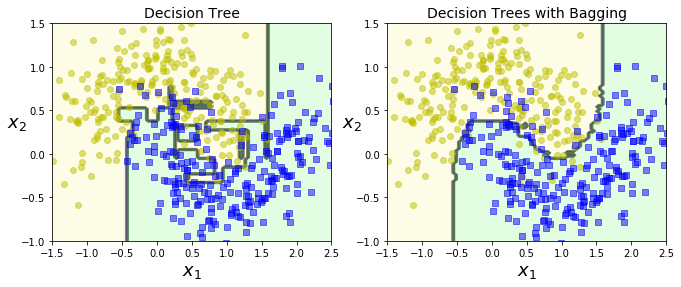

In [9]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
#save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### The ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble’s variance is reduced.

 Overall, bagging often results in better models, which explains why it is gen‐ erally preferred. However, if you have spare time and CPU power you can use cross- validation to evaluate both bagging and pasting and select the one that works best.
 
 By default a BaggingClassifier samples m training instances with replacement (bootstrap=True), where m is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor.6 The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors.
Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

`oob_score=True` when creating a BaggingClassifier to request an automatic oob evaluation after training.

In [10]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True);
bag_clf.fit(X_train, y_train);
bag_clf.oob_score_

0.91

In [11]:
y_pred = bag_clf.predict(X_test);
accuracy_score(y_test, y_pred)

0.88

`max_samples`: `int` or `float`, optional (default=`1.0`)
The number of samples to draw from X to train each base estimator.
 - If int, then draw `max_samples` samples.
 - If float, then draw `max_samples * X.shape[0]` samples.

#### The BaggingClassifier class supports sampling the features as well. This is controlled by two hyperparameters: `max_features` and `bootstrap_features`. They work the same way as max_samples and bootstrap, but for feature sampling instead of instance sampling.

It is useful when you are dealing with high-dimensional inputs (such as images). 

 - **Random Patches method**: sampling both training instances and features. 

 - **Random Subspaces**: Keeping all training instances (i.e., `bootstrap=False` and `max_samples=1.0`) and sampling features (i.e., `bootstrap_features=True` and/or `max_features` smaller than `1.0`).

# Random forest
As we have discussed, a Random Forest9 is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set. Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can instead use the `RandomForestClassifier` class, which is more convenient and optimized for Decision Trees (similarly, there is a `RandomForestRegressor` class for regression tasks).

In [12]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)


### the above is equivalent to the below:

In [13]:
bag_clf = BaggingClassifier(
         DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
         n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node (see Chapter 6), it searches for the best feature among a random subset of features. his results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model.

# Extra-trees
It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds.
    A forest of such extremely random trees is simply called an Extremely Randomized Trees ensemble.

# Feature importance of Random Forests
Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.

The value is into the `feature_importances_` variable:

In [14]:
>>> from sklearn.datasets import load_iris
>>> iris = load_iris()
>>> rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
>>> rnd_clf.fit(iris["data"], iris["target"])
>>> for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10004231610704496
sepal width (cm) 0.02189056113033422
petal length (cm) 0.43345014548664124
petal width (cm) 0.4446169772759798


#### Similarly, if you train a Random Forest classifier on the MNIST dataset

In [15]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
    
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

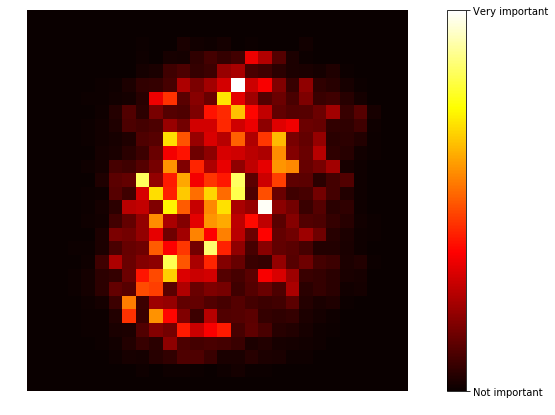

In [16]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plt.figure(figsize=(14,7))
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

#save_fig("mnist_feature_importance_plot")
plt.show()

# Boosting
refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. 
 - Adaboost (Adaptive Boosting)
 - Gradient Boosting
 


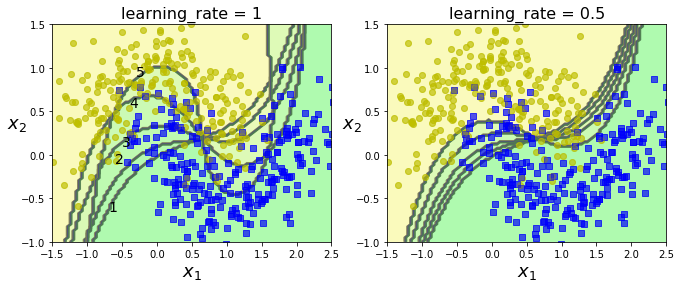

In [18]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

#save_fig("boosting_plot")
plt.show()

 ## Adaboost
 The next predictor corrects or pays more attention to the training instances that the predecessor underfitted. For example, to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased.

All the weights are initialised to $\frac{1}{m}$ and the first predictor is trained. The weighted error rate $r_1$ is computed on the training set:

$$r_j = \frac{\sum_{i=1}^m w^{(i)}(\hat{y}^{(i)}\ne y^{(i)})}{\sum_{i=1}^m w^{(i)}}$$

The predictor's weight $\alpha_j$ is then computed using a learning rate $\eta$ with default value to $1$. The more accurate the predictor is the higher the weight will be. If it is guessing randomly it is close to $0$, if it is more often wrong, it will have a negative value.

$$\alpha_j = \eta \log \frac{1-r_j}{r_j}$$

Next the instance wights are updated by boosting the missclassified instances.

$for i=1,\cdots, m:$

$w^{(i)} = w^{(i)} if \hat{y}^{(i)} = y^{(i)}$

$w^{(i)} = w^{(i)}e^{\alpha_j} if \hat{y}^{(i)} \ne y^{(i)}$
Then the weifhts are normalized by $\sum_{i=1}^m w^{(i)}$ and majoring vote is classified.

Scikit-Learn actually uses a multiclass version of AdaBoost called SAMME16 (which stands for Stagewise Additive Modeling using a Multiclass Exponential loss function). When there are just two classes, SAMME is equivalent to AdaBoost. Moreover, if the predictors can estimate class probabilities (i.e., if they have a predict_proba() method), Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better.

The following code trains an AdaBoost classifier based on 200 Decision Stumps using Scikit-Learn’s AdaBoostClassifier class (as you might expect, there is also an Ada BoostRegressor class). A Decision Stump is a Decision Tree with max_depth=1—in other words, a tree composed of a single decision node plus two leaf nodes. This is the default base estimator for the AdaBoostClassifier class:

In [22]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), 
          n_estimators=200, algorithm="SAMME.R", learning_rate=0.5);
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=None)

## Gradient boosting
Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

In [35]:
#Regression example
from sklearn.tree import DecisionTreeRegressor
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
tree_reg1 = DecisionTreeRegressor(max_depth=2);
tree_reg1.fit(X, y);
#train a second tree on the residual error:
y2 = y - tree_reg1.predict(X);
tree_reg2 = DecisionTreeRegressor(max_depth=2);
tree_reg2.fit(X, y2)
y3 = y - tree_reg2.predict(X);
tree_reg3 = DecisionTreeRegressor(max_depth=2);
tree_reg3.fit(X, y3);

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [36]:
y_pred = sum(tree.predict(X) for tree in (tree_reg, tree_reg2, tree_reg3))

ValueError: Number of features of the model must match the input. Model n_features is 2 and input n_features is 1 

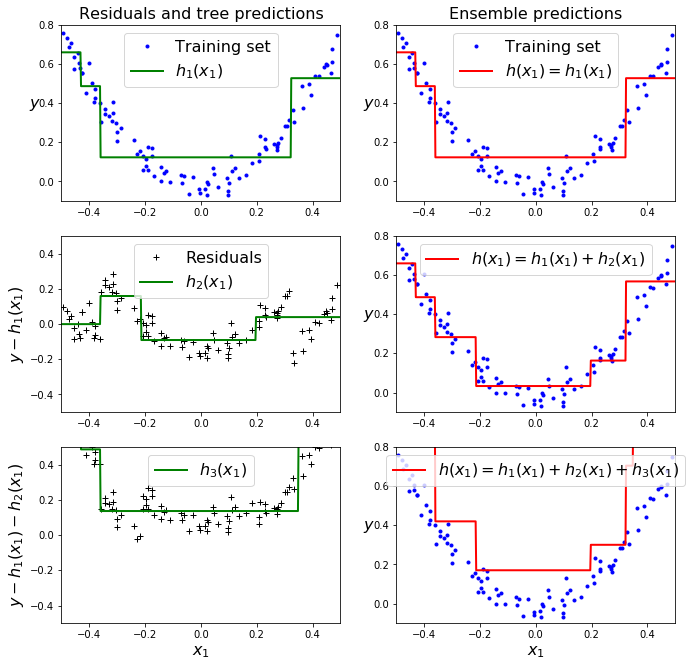

In [37]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

The learning_rate hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the train‐ ing set, but the predictions will usually generalize better. This a *srhinkage*.

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [40]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

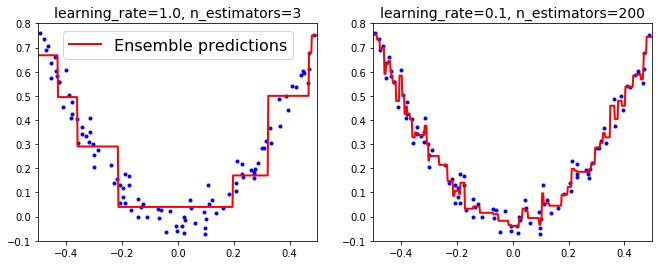

In [43]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

#save_fig("gbrt_learning_rate_plot")
plt.show()

 the one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set.

## Gradient boosting with early stopping
In order to find the optimal number of trees, you can use early stopping (see Chap‐ ter 4). A simple way to implement this is to use the `staged_predict()` method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=49);
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42);
gbrt.fit(X_train, y_train);
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors)+1;
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators);
gbrt_best.fit(X_train, y_train);

In [6]:
min_error = np.min(errors)
min_error

0.002712853325235463

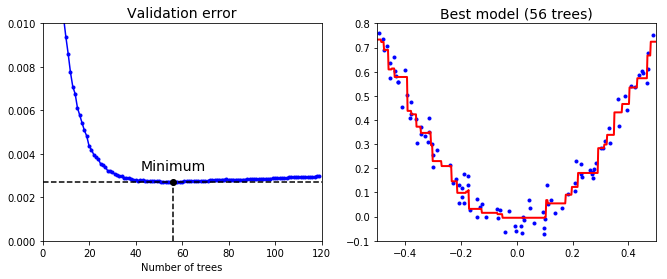

In [74]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)

#save_fig("early_stopping_gbrt_plot")
plt.show()

It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). You can do so by setting `warm_start=True`.The following code stops training when the validation error does not improve for five iterations in a row:

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5;
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100);
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=49);


gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True);
min_val_error = float("inf");
error_going_up = 0;
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators;
    gbrt.fit(X_train, y_train);
    y_pred = gbrt.predict(X_val);
    val_err = mean_squared_error(y_val, y_pred);
    if val_err< min_val_error:
        min_val_error = val_err
    else:
        error_going_up +=1;
        if error_going_up == 5:
            break;

The GradientBoostingRegressor class also supports a subsample hyperparameter, which specifies the fraction of training instances to be used for training each tree.  As you can probably guess by now, this trades a higher bias for a lower variance. It also speeds up training considerably. This technique is called **Stochastic Gradient Boosting**.

### Another libray XGBoost
It is worth noting that an optimized implementation of Gradient Boosting is available in the popular python library **XGBoost**, which stands for *Extreme Gradient Boosting*. This package was initially developed by Tianqi Chen as part of the Distributed (Deep) Machine Learning Community (DMLC), and it aims at being extremely fast, scalable and portable. In fact, XGBoost is often an important component of the winning entries in ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s:

In [8]:
!pip install xgboost

In [9]:
import xgboost
X = np.random.rand(100, 1) - 0.5;
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100);
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=49);

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[15:05:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Stacking
It is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation?

Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor (called a blender, or a meta learner) takes these predictions as inputs and makes the final prediction (3.0).

To train the blender, a common approach is to use a hold-out set.19 Let’s see how it works. First, the training set is split in two subsets. The first subset is used to train the predictors in the first layer.
Next, the first layer predictors are used to make predictions on the second (held-out) set. This ensures that the predictions are “clean,” since the predictors never saw these instances during training.

For each instance in the hold-out (1st) set, there are three predicted values. We can create a new training set using these predic‐ ted values as input features (which makes this new training set three-dimensional), and keeping the target values. The blender is trained on this new training set, so it learns to predict the target value given the first layer’s predictions.

It is actually possible to train several different blenders this way (e.g., one using Linear Regression, another using Random Forest Regression, and so on): we get a whole layer of blenders. The trick is to split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using pre‐ dictions made by the predictors of the second layer). Once this is done, we can make a prediction for a new instance by going through each layer sequentially,